In [1]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

import random
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

2.2.0


### 데이터 불러오기

In [2]:
DATASET_PATH=os.path.join(os.getenv('HOME'),'aiffel/medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [3]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [4]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [5]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 480
Number of test examples: 120


### 샘플 확인하기

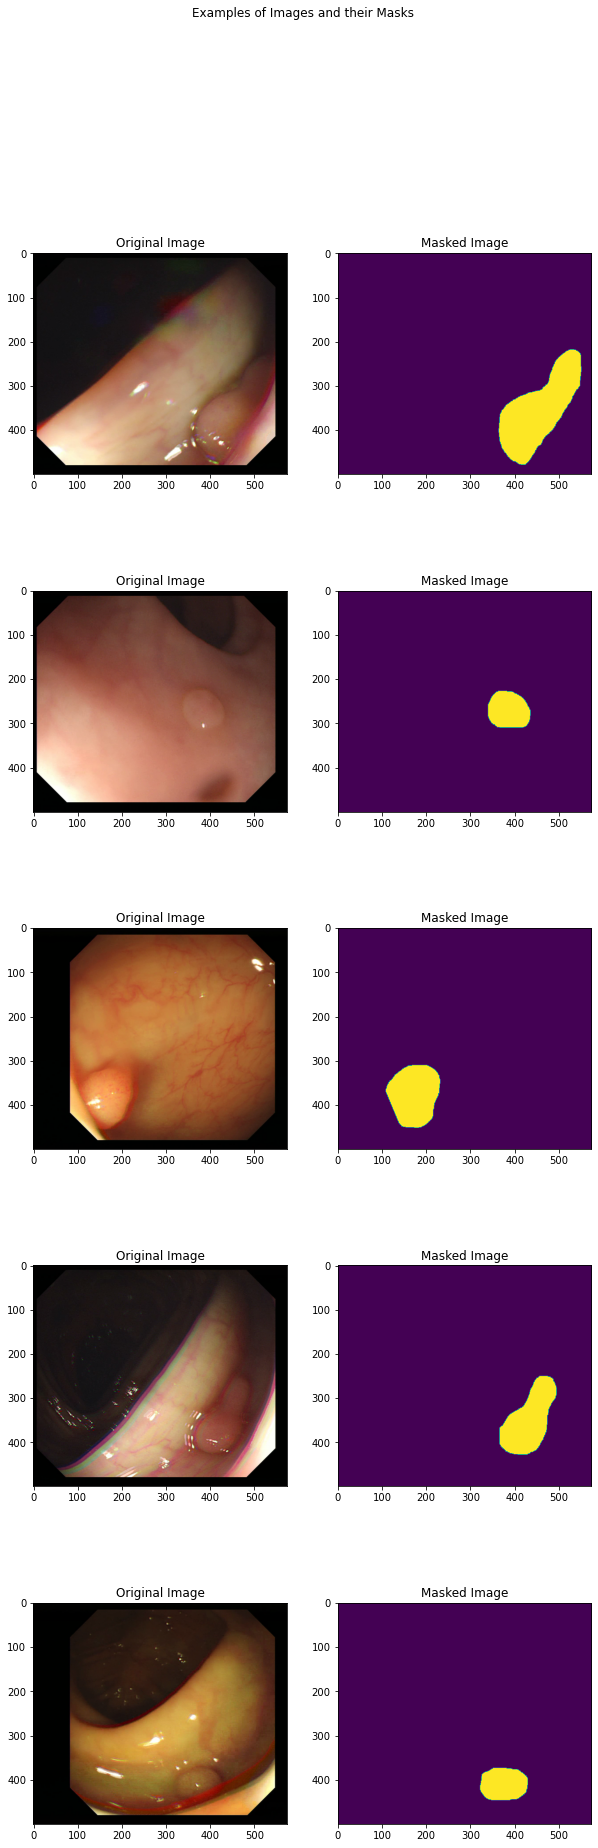

In [6]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 30))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

In [7]:
# Set hyperparameters

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 4
max_epochs = 100

### Processing each pathname

In [8]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3) # RGB

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=1) # BMP 0,1

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

### Data augmentation - Shifting the image

In [9]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

### Data augmentation - Flipping the image randomly

In [10]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

### Data augmentation Assembling

In [11]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

### Set up train and test datasets

In [12]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [13]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

### Plot some train data

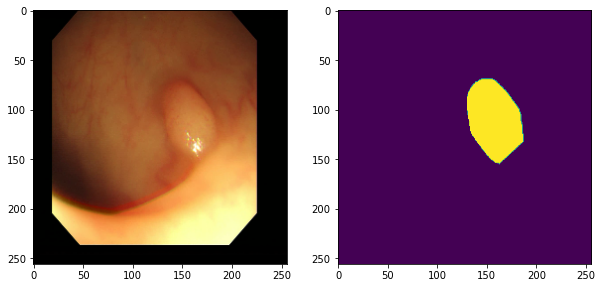

In [14]:
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

# 모델 빌드하기

## Encoder-Decoder architecture

In [15]:
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

In [16]:
# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print(bottleneck.shape)   # (batch_size, 16, 16, 512) 이 나오는지 확인

(4, 16, 16, 512)


In [17]:
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

In [18]:
# decoder 제대로 만들어졌는지 확인

predictions = decoder(bottleneck)
print(predictions.shape)    # (batch_size, 256, 256, 1) 이 나오는지 확인

(4, 256, 256, 1)


In [19]:
ed_model = tf.keras.Sequential()

ed_model.add(encoder)
ed_model.add(decoder)

## U-Net architecture

In [39]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [40]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [41]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [42]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

In [43]:
unet_model = UNet()

### VGG16

In [62]:
vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
layer_outputs = [layer.output for layer in vgg16.layers]
layer_outputs

[<tf.Tensor 'input_1:0' shape=(None, 256, 256, 3) dtype=float32>,
 <tf.Tensor 'block1_conv1/Identity:0' shape=(None, 256, 256, 64) dtype=float32>,
 <tf.Tensor 'block1_conv2/Identity:0' shape=(None, 256, 256, 64) dtype=float32>,
 <tf.Tensor 'block1_pool/Identity:0' shape=(None, 128, 128, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1/Identity:0' shape=(None, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'block2_conv2/Identity:0' shape=(None, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'block2_pool/Identity:0' shape=(None, 64, 64, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1/Identity:0' shape=(None, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'block3_conv2/Identity:0' shape=(None, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'block3_conv3/Identity:0' shape=(None, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'block3_pool/Identity:0' shape=(None, 32, 32, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1/Identity:0' shape=(None, 32, 32, 512) dtype=float32>,
 <tf.Tensor 'block4_conv2/Identity:0' shape=(None,

In [63]:
class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13], 
                                               layer_outputs[17]])


        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):

        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs) 
        
        center = self.center(center)
        
        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)

        return outputs

In [64]:
vgg_model = Vgg16UNet()

## metrics과 loss functions

In [65]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [66]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [67]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [68]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

# 3가지 모델을 분석하여 결과를 비교해 보도록하겠습니다.

# Encoder-Decoder model

In [24]:
print('select the Encoder-Decoder model')
model = ed_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

select the Encoder-Decoder model


### Compile

In [25]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(4, 256, 256, 1)


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         multiple                  4693056   
_________________________________________________________________
decoder (Sequential)         multiple                  2354913   
Total params: 7,047,969
Trainable params: 7,042,209
Non-trainable params: 5,760
_________________________________________________________________


### Callbacks

In [27]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [28]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

# Train model

In [29]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

In [30]:
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 100
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )


Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
Epoch 1/100
120/120 [==============================] - 9s 76ms/step - loss: 1.1735 - dice_loss: 0.7875 - val_loss: 1.1044 - val_dice_loss: 0.7729 - lr: 0.0010

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009997532, shape=(), dtype=float32).
Epoch 2/100
120/120 [==============================] - 9s 74ms/step - loss: 0.9592 - dice_loss: 0.7296 - val_loss: 0.9792 - val_dice_loss: 0.7384 - lr: 9.9975e-04

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990134, shape=(), dtype=float32).
Epoch 3/100
120/120 [==============================] - 9s 74ms/step - loss: 0.9192 - dice_loss: 0.7096 - val_loss: 1.0248 - val_dice_loss: 0.7416 - lr: 9.9901e-04

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.000997781, shape=(), dtype=float32).
Epoch 4/100
120/120 [==============================] - 9s 75ms/step - loss:

120/120 [==============================] - 9s 75ms/step - loss: 0.1437 - dice_loss: 0.1064 - val_loss: 0.1656 - val_dice_loss: 0.1232 - lr: 8.0645e-04

Epoch 00031: LearningRateScheduler reducing learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
Epoch 31/100
120/120 [==============================] - 9s 74ms/step - loss: 0.1376 - dice_loss: 0.1023 - val_loss: 0.2007 - val_dice_loss: 0.1503 - lr: 7.9389e-04

Epoch 00032: LearningRateScheduler reducing learning rate to tf.Tensor(0.0007810417, shape=(), dtype=float32).
Epoch 32/100
120/120 [==============================] - 9s 74ms/step - loss: 0.1328 - dice_loss: 0.0981 - val_loss: 0.1767 - val_dice_loss: 0.1294 - lr: 7.8104e-04

Epoch 00033: LearningRateScheduler reducing learning rate to tf.Tensor(0.00076791336, shape=(), dtype=float32).
Epoch 33/100
120/120 [==============================] - 9s 74ms/step - loss: 0.1370 - dice_loss: 0.1019 - val_loss: 0.2023 - val_dice_loss: 0.1495 - lr: 7.6791e-04

Epoch 00034: Learn

120/120 [==============================] - 9s 76ms/step - loss: 0.0612 - dice_loss: 0.0453 - val_loss: 0.0820 - val_dice_loss: 0.0589 - lr: 3.6050e-04

Epoch 00061: LearningRateScheduler reducing learning rate to tf.Tensor(0.00034549143, shape=(), dtype=float32).
Epoch 61/100
120/120 [==============================] - 10s 81ms/step - loss: 0.0551 - dice_loss: 0.0409 - val_loss: 0.0819 - val_dice_loss: 0.0583 - lr: 3.4549e-04

Epoch 00062: LearningRateScheduler reducing learning rate to tf.Tensor(0.00033063104, shape=(), dtype=float32).
Epoch 62/100
120/120 [==============================] - 9s 79ms/step - loss: 0.0515 - dice_loss: 0.0382 - val_loss: 0.0893 - val_dice_loss: 0.0637 - lr: 3.3063e-04

Epoch 00063: LearningRateScheduler reducing learning rate to tf.Tensor(0.0003159377, shape=(), dtype=float32).
Epoch 63/100
120/120 [==============================] - 10s 81ms/step - loss: 0.0550 - dice_loss: 0.0409 - val_loss: 0.0781 - val_dice_loss: 0.0565 - lr: 3.1594e-04

Epoch 00064: Lea

120/120 [==============================] - 9s 76ms/step - loss: 0.0385 - dice_loss: 0.0286 - val_loss: 0.0670 - val_dice_loss: 0.0473 - lr: 2.9560e-05

Epoch 00091: LearningRateScheduler reducing learning rate to tf.Tensor(2.4471761e-05, shape=(), dtype=float32).
Epoch 91/100
120/120 [==============================] - 9s 76ms/step - loss: 0.0393 - dice_loss: 0.0290 - val_loss: 0.0684 - val_dice_loss: 0.0480 - lr: 2.4472e-05

Epoch 00092: LearningRateScheduler reducing learning rate to tf.Tensor(1.9853116e-05, shape=(), dtype=float32).
Epoch 92/100
120/120 [==============================] - 9s 76ms/step - loss: 0.0391 - dice_loss: 0.0290 - val_loss: 0.0668 - val_dice_loss: 0.0471 - lr: 1.9853e-05

Epoch 00093: LearningRateScheduler reducing learning rate to tf.Tensor(1.5708387e-05, shape=(), dtype=float32).
Epoch 93/100
120/120 [==============================] - 9s 76ms/step - loss: 0.0390 - dice_loss: 0.0290 - val_loss: 0.0654 - val_dice_loss: 0.0463 - lr: 1.5708e-05

Epoch 00094: Lear

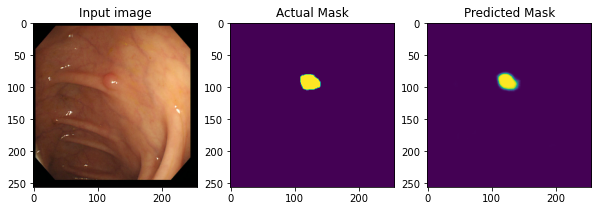

In [31]:
# print sample image after training
print_images()

### Plot the loss

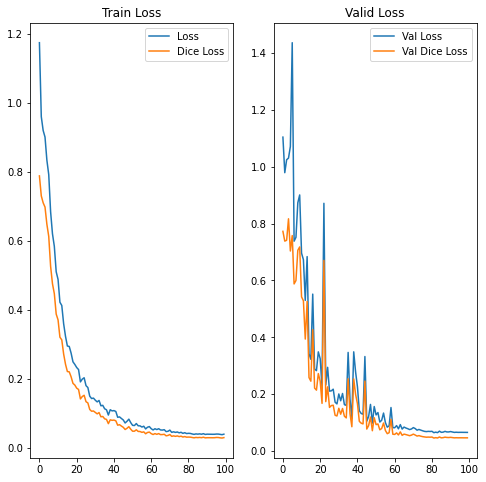

In [32]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [33]:
# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

### Evaluate the test dataset

In [34]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [35]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.9390762634366321


In [36]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

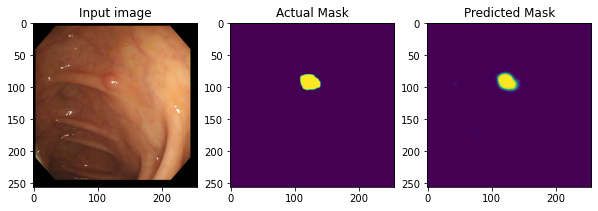

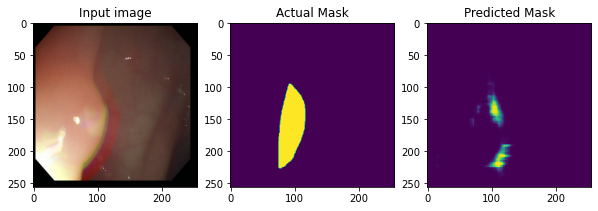

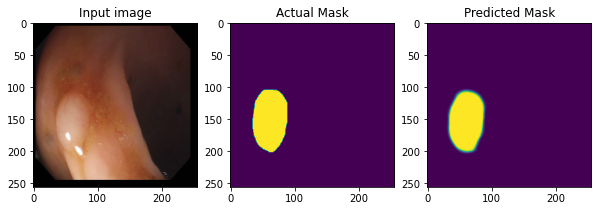

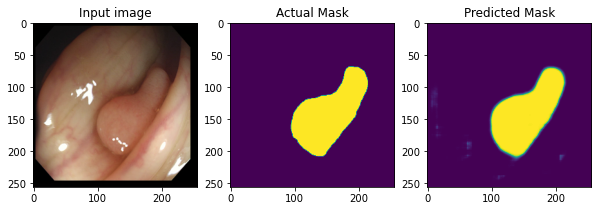

In [37]:
print_images()

# U-Net model

In [48]:
print('select the U-Net model')
model = unet_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/unet_model')

select the U-Net model


### Compile

In [49]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(4, 256, 256, 1)


In [50]:
model.summary()

Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block (EncoderBlock) multiple                  76416     
_________________________________________________________________
encoder_block_1 (EncoderBloc multiple                  444288    
_________________________________________________________________
encoder_block_2 (EncoderBloc multiple                  1773312   
_________________________________________________________________
encoder_block_3 (EncoderBloc multiple                  7085568   
_________________________________________________________________
conv_block_4 (ConvBlock)     multiple                  28326912  
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  18882048  
_________________________________________________________________
decoder_block_1 (DecoderBloc multiple                  354278

### Callbacks

In [51]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [52]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

# Train model

In [53]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

In [54]:
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 100
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )


Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
Epoch 1/100
120/120 [==============================] - 40s 333ms/step - loss: 0.9664 - dice_loss: 0.7146 - val_loss: 1.9387 - val_dice_loss: 0.9944 - lr: 0.0010

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009997532, shape=(), dtype=float32).
Epoch 2/100
120/120 [==============================] - 40s 332ms/step - loss: 0.8372 - dice_loss: 0.6449 - val_loss: 1.1303 - val_dice_loss: 0.7493 - lr: 9.9975e-04

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990134, shape=(), dtype=float32).
Epoch 3/100
120/120 [==============================] - 39s 323ms/step - loss: 0.7657 - dice_loss: 0.5923 - val_loss: 1.4040 - val_dice_loss: 0.7833 - lr: 9.9901e-04

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.000997781, shape=(), dtype=float32).
Epoch 4/100
120/120 [==============================] - 40s 334ms/step

120/120 [==============================] - 39s 327ms/step - loss: 0.0842 - dice_loss: 0.0622 - val_loss: 0.1306 - val_dice_loss: 0.0976 - lr: 8.0645e-04

Epoch 00031: LearningRateScheduler reducing learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
Epoch 31/100
120/120 [==============================] - 39s 325ms/step - loss: 0.0936 - dice_loss: 0.0699 - val_loss: 0.1097 - val_dice_loss: 0.0816 - lr: 7.9389e-04

Epoch 00032: LearningRateScheduler reducing learning rate to tf.Tensor(0.0007810417, shape=(), dtype=float32).
Epoch 32/100
120/120 [==============================] - 40s 329ms/step - loss: 0.0979 - dice_loss: 0.0727 - val_loss: 0.4203 - val_dice_loss: 0.2950 - lr: 7.8104e-04

Epoch 00033: LearningRateScheduler reducing learning rate to tf.Tensor(0.00076791336, shape=(), dtype=float32).
Epoch 33/100
120/120 [==============================] - 39s 325ms/step - loss: 0.1025 - dice_loss: 0.0756 - val_loss: 0.1436 - val_dice_loss: 0.1056 - lr: 7.6791e-04

Epoch 0003


Epoch 00060: LearningRateScheduler reducing learning rate to tf.Tensor(0.00036050452, shape=(), dtype=float32).
Epoch 60/100
120/120 [==============================] - 39s 327ms/step - loss: 0.0442 - dice_loss: 0.0326 - val_loss: 0.0596 - val_dice_loss: 0.0435 - lr: 3.6050e-04

Epoch 00061: LearningRateScheduler reducing learning rate to tf.Tensor(0.00034549143, shape=(), dtype=float32).
Epoch 61/100
120/120 [==============================] - 39s 325ms/step - loss: 0.0432 - dice_loss: 0.0321 - val_loss: 0.0547 - val_dice_loss: 0.0395 - lr: 3.4549e-04

Epoch 00062: LearningRateScheduler reducing learning rate to tf.Tensor(0.00033063104, shape=(), dtype=float32).
Epoch 62/100
120/120 [==============================] - 39s 325ms/step - loss: 0.0435 - dice_loss: 0.0322 - val_loss: 0.0545 - val_dice_loss: 0.0401 - lr: 3.3063e-04

Epoch 00063: LearningRateScheduler reducing learning rate to tf.Tensor(0.0003159377, shape=(), dtype=float32).
Epoch 63/100
120/120 [=============================

120/120 [==============================] - 39s 326ms/step - loss: 0.0327 - dice_loss: 0.0242 - val_loss: 0.0491 - val_dice_loss: 0.0357 - lr: 3.5112e-05

Epoch 00090: LearningRateScheduler reducing learning rate to tf.Tensor(2.9559613e-05, shape=(), dtype=float32).
Epoch 90/100
120/120 [==============================] - 39s 323ms/step - loss: 0.0321 - dice_loss: 0.0236 - val_loss: 0.0490 - val_dice_loss: 0.0356 - lr: 2.9560e-05

Epoch 00091: LearningRateScheduler reducing learning rate to tf.Tensor(2.4471761e-05, shape=(), dtype=float32).
Epoch 91/100
120/120 [==============================] - 39s 323ms/step - loss: 0.0330 - dice_loss: 0.0245 - val_loss: 0.0489 - val_dice_loss: 0.0356 - lr: 2.4472e-05

Epoch 00092: LearningRateScheduler reducing learning rate to tf.Tensor(1.9853116e-05, shape=(), dtype=float32).
Epoch 92/100
120/120 [==============================] - 39s 323ms/step - loss: 0.0327 - dice_loss: 0.0242 - val_loss: 0.0479 - val_dice_loss: 0.0348 - lr: 1.9853e-05

Epoch 000

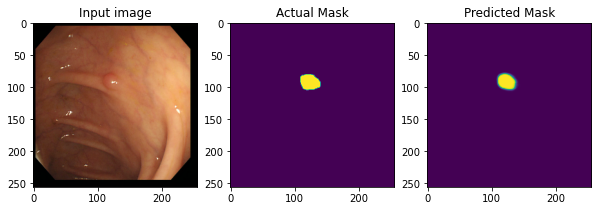

In [55]:
# print sample image after training
print_images()

### Plot the loss

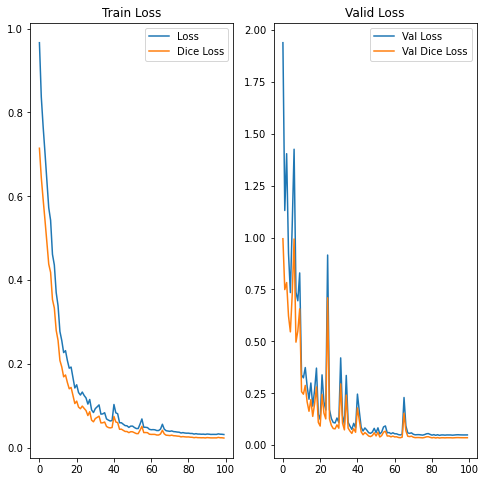

In [56]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [57]:
# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

### Evaluate the test dataset

In [58]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [59]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.9513054388820181


In [60]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

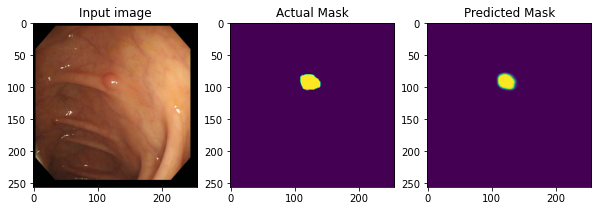

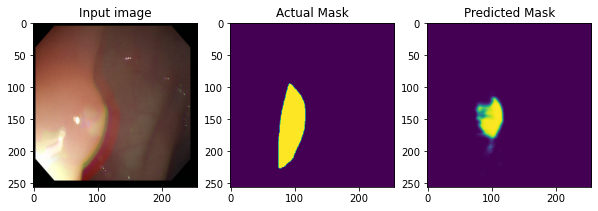

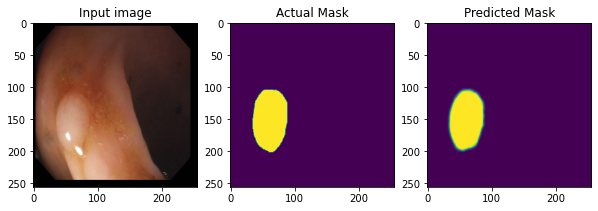

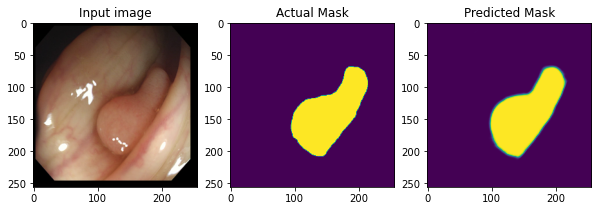

In [61]:
print_images()

# VGG16_U_Net model

In [69]:
print('select the VGG16_U_Net model')
model = vgg_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/unet_model')

select the VGG16_U_Net model


### Compile

In [70]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(4, 256, 256, 1)


In [71]:
model.summary()

Model: "vgg16u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
model (Model)                [(None, 256, 256, 64), (N 14714688  
_________________________________________________________________
conv_block_5 (ConvBlock)     multiple                  23608320  
_________________________________________________________________
decoder_block_4 (DecoderBloc multiple                  16522752  
_________________________________________________________________
decoder_block_5 (DecoderBloc multiple                  2952960   
_________________________________________________________________
decoder_block_6 (DecoderBloc multiple                  739200    
_________________________________________________________________
decoder_block_7 (DecoderBloc multiple                  1

### Callbacks

In [72]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [73]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

# Train model

In [74]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

In [75]:
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 100
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )


Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
Epoch 1/100
120/120 [==============================] - 31s 262ms/step - loss: 0.8367 - dice_loss: 0.6234 - val_loss: 1.5460 - val_dice_loss: 0.9998 - lr: 0.0010

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009997532, shape=(), dtype=float32).
Epoch 2/100
120/120 [==============================] - 30s 251ms/step - loss: 0.7133 - dice_loss: 0.5489 - val_loss: 1.7854 - val_dice_loss: 0.8006 - lr: 9.9975e-04

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990134, shape=(), dtype=float32).
Epoch 3/100
120/120 [==============================] - 31s 262ms/step - loss: 0.6761 - dice_loss: 0.5206 - val_loss: 0.8609 - val_dice_loss: 0.6665 - lr: 9.9901e-04

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.000997781, shape=(), dtype=float32).
Epoch 4/100
120/120 [==============================] - 31s 259ms/step

120/120 [==============================] - 30s 254ms/step - loss: 0.1598 - dice_loss: 0.1193 - val_loss: 0.1738 - val_dice_loss: 0.1298 - lr: 8.0645e-04

Epoch 00031: LearningRateScheduler reducing learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
Epoch 31/100
120/120 [==============================] - 31s 259ms/step - loss: 0.1130 - dice_loss: 0.0830 - val_loss: 0.1594 - val_dice_loss: 0.1198 - lr: 7.9389e-04

Epoch 00032: LearningRateScheduler reducing learning rate to tf.Tensor(0.0007810417, shape=(), dtype=float32).
Epoch 32/100
120/120 [==============================] - 33s 277ms/step - loss: 0.0996 - dice_loss: 0.0729 - val_loss: 0.0929 - val_dice_loss: 0.0687 - lr: 7.8104e-04

Epoch 00033: LearningRateScheduler reducing learning rate to tf.Tensor(0.00076791336, shape=(), dtype=float32).
Epoch 33/100
120/120 [==============================] - 32s 264ms/step - loss: 0.0968 - dice_loss: 0.0707 - val_loss: 0.1934 - val_dice_loss: 0.1444 - lr: 7.6791e-04

Epoch 0003


Epoch 00060: LearningRateScheduler reducing learning rate to tf.Tensor(0.00036050452, shape=(), dtype=float32).
Epoch 60/100
120/120 [==============================] - 32s 263ms/step - loss: 0.0417 - dice_loss: 0.0308 - val_loss: 0.0585 - val_dice_loss: 0.0422 - lr: 3.6050e-04

Epoch 00061: LearningRateScheduler reducing learning rate to tf.Tensor(0.00034549143, shape=(), dtype=float32).
Epoch 61/100
120/120 [==============================] - 30s 253ms/step - loss: 0.0406 - dice_loss: 0.0299 - val_loss: 0.0599 - val_dice_loss: 0.0441 - lr: 3.4549e-04

Epoch 00062: LearningRateScheduler reducing learning rate to tf.Tensor(0.00033063104, shape=(), dtype=float32).
Epoch 62/100
120/120 [==============================] - 32s 263ms/step - loss: 0.0423 - dice_loss: 0.0314 - val_loss: 0.0574 - val_dice_loss: 0.0414 - lr: 3.3063e-04

Epoch 00063: LearningRateScheduler reducing learning rate to tf.Tensor(0.0003159377, shape=(), dtype=float32).
Epoch 63/100
120/120 [=============================

120/120 [==============================] - 30s 253ms/step - loss: 0.0298 - dice_loss: 0.0219 - val_loss: 0.0510 - val_dice_loss: 0.0363 - lr: 3.5112e-05

Epoch 00090: LearningRateScheduler reducing learning rate to tf.Tensor(2.9559613e-05, shape=(), dtype=float32).
Epoch 90/100
120/120 [==============================] - 30s 254ms/step - loss: 0.0297 - dice_loss: 0.0218 - val_loss: 0.0507 - val_dice_loss: 0.0360 - lr: 2.9560e-05

Epoch 00091: LearningRateScheduler reducing learning rate to tf.Tensor(2.4471761e-05, shape=(), dtype=float32).
Epoch 91/100
120/120 [==============================] - 30s 253ms/step - loss: 0.0299 - dice_loss: 0.0220 - val_loss: 0.0509 - val_dice_loss: 0.0362 - lr: 2.4472e-05

Epoch 00092: LearningRateScheduler reducing learning rate to tf.Tensor(1.9853116e-05, shape=(), dtype=float32).
Epoch 92/100
120/120 [==============================] - 30s 253ms/step - loss: 0.0298 - dice_loss: 0.0219 - val_loss: 0.0506 - val_dice_loss: 0.0360 - lr: 1.9853e-05

Epoch 000

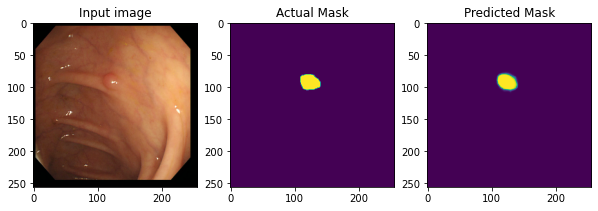

In [76]:
# print sample image after training
print_images()

### Plot the loss

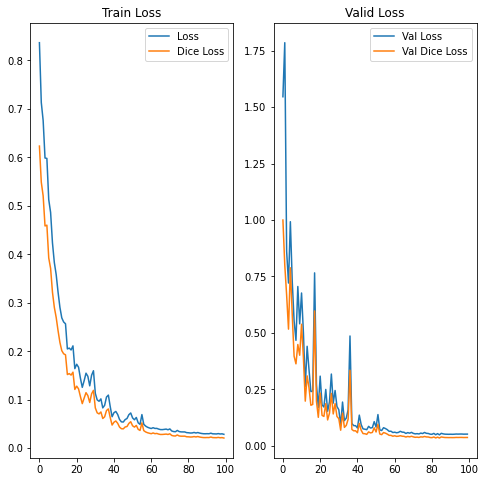

In [77]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [78]:
# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

### Evaluate the test dataset

In [79]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [80]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.9518480482180568


In [81]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

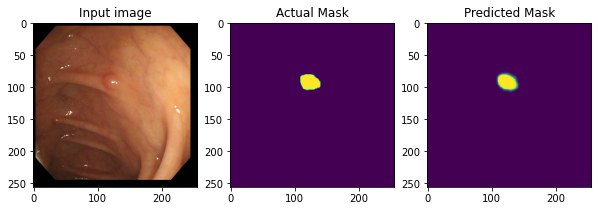

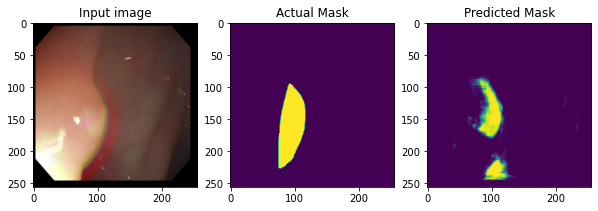

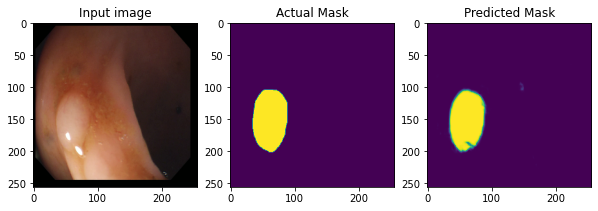

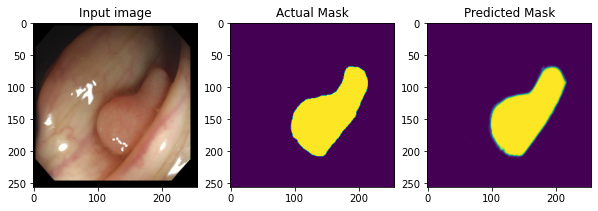

In [82]:
print_images()

# 평가 및 결과

Encoder-Decoder, U-Net, VGG16 모델을 사용하여 의료영상에서 용종을 검출해보는 시간을 가졌습니다.  
결과는 VGG16_U_Net, U_Net ,Encoder-Decoder순으로 좋은 성능이 나왔습니다.  
U_net을 변형시킨 모델인 VGG16_U_Net은 매우매우 근소하지만 성능의 개선을 가져왔습니다.  
학습횟수를 더 늘린다면 더 나은 성능 차이를 느낄수도 있을것 같습니다!  